In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import re
import random
import csv

/home/ziyi/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# Network Parameters
num_input = 6
timesteps = 50 # timesteps
num_hidden = 100 # hidden layer num of features
num_output= 1

In [3]:
def read_sensor(filename):
    with open(filename, "r") as csvfile:
        reader = csv.reader(csvfile)
        dataset = [row[17:23] for row in reader]
        #data_x
        return np.array(dataset)
    
def read_xml(filename, length):
    f = open(filename)
    cts = f.read()
    f.close()

    p_foot = re.compile(r'<WhichFoot>(.*?)</WhichFoot>')
    all_foot = p_foot.findall(cts)

    p_time = re.compile(r'<Time>(.*?)</Time>')
    all_time = p_time.findall(cts)

    strike_times = []
    #L-1 R-0
    strike_times.append([0.0, 0.5])
    for i in range(len(all_foot)):
        if(all_foot[i]=='L'):
            strike_times.append([float(all_time[i]), 1])
        else:
            strike_times.append([float(all_time[i]), 0])
    strike_times[-1][1] = 0.5
    strike_times.append([length/25.0, 0.5])

    window_y = []
    strike_index=0
    for i in range(length):
        if(i/25.0 >= strike_times[strike_index+1][0]):
            strike_index += 1
        window_y.append([strike_times[strike_index][1]])

    p_info = re.compile(r'<StartTime>(.*?)</StartTime>\n\t<EndTime>(.*?)</EndTime>\n\t<NSteps>(.*?)</NSteps>\n\t<Direction>(.*?)</Direction>')
    all_info = p_info.findall(cts)#start_time, end_time, step_num, direction=turn

    for i in range(len(all_info)):
        if(all_info[i][3][:4]=='Turn'):
#             print(all_info[i])
            start_time = int(float(all_info[i][0])*25)
            end_time = int(float(all_info[i][1])*25)
#             print('start and end time : ', all_info[i][0], all_info[i][1])
            for t in range(start_time-1, end_time):
                window_y[t] = [0.5]

    p_feature = re.compile(r'<Feature>\n\t\t\t<StartTime>(.*?)</StartTime>\n\t\t\t<EndTime>(.*?)</EndTime>')
    all_feature = p_feature.findall(cts)#start_time, end_time, step_num, direction=turn

    for i in range(len(all_feature)):
        start_time = int(float(all_feature[i][0])*25)
        end_time = int(float(all_feature[i][1])*25)
        for t in range(start_time-1, end_time):
            window_y[t] = [0.5]
            
#     print(len(window_y))  
    return window_y

def add_data(path, person, phone_location, assistant):
    data_x = read_sensor('weallwalk/sensor/iPhoneSensors_T'+str(path)+'_ID'+str(person)+'_'+phone_location+'_'+assistant+'.csv')
    data_y = read_xml('weallwalk/xml/T'+str(path)+'_ID'+str(person)+'_'+assistant+'.xml', len(data_x))
    
    split_x, split_x_part = [], []
    split_y, split_y_part = [], []
    for i in range(len(data_y)):
        if(data_y[i][0]!=0.5):
            split_y_part.append(data_y[i])
            split_x_part.append(data_x[i])
        else:
            if(len(split_y_part)>0):
                split_y.append(split_y_part)
                split_x.append(split_x_part)
                split_y_part = []
                split_x_part = []
    
    data_x_seq, data_y_seq = [], []
    for i in range(len(split_x)):
        data_x_part, data_y_part = [], []
        for j in range(len(split_x[i])-timesteps):
            x = split_x[i][j:j+timesteps]
            y = split_y[i][j:j+timesteps]
            data_x_part.append(x)
            data_y_part.append(y)
        if(len(data_x_part)>0):
            data_x_seq.append(data_x_part)
            data_y_seq.append(data_y_part)
    
    return data_x_seq, data_y_seq

In [4]:
step_data_list = []
for i in range(1,7):
    step_data_list.append([i, 11, '1L', 'NA'])
    step_data_list.append([i, 12, '1L', 'NA'])
    step_data_list.append([i, 13, '1L', 'NA'])
    step_data_list.append([i, 14, '1L', 'NA'])
#     step_data_list.append([i, 15, '1L', 'NA'])
    step_data_list.append([i, 11, '2R', 'NA'])
    step_data_list.append([i, 12, '2R', 'NA'])
    step_data_list.append([i, 13, '2R', 'NA'])
    step_data_list.append([i, 14, '2R', 'NA'])
#     step_data_list.append([i, 15, '2R', 'NA'])    
    
print(step_data_list)

[[1, 11, '1L', 'NA'], [1, 12, '1L', 'NA'], [1, 13, '1L', 'NA'], [1, 14, '1L', 'NA'], [1, 11, '2R', 'NA'], [1, 12, '2R', 'NA'], [1, 13, '2R', 'NA'], [1, 14, '2R', 'NA'], [2, 11, '1L', 'NA'], [2, 12, '1L', 'NA'], [2, 13, '1L', 'NA'], [2, 14, '1L', 'NA'], [2, 11, '2R', 'NA'], [2, 12, '2R', 'NA'], [2, 13, '2R', 'NA'], [2, 14, '2R', 'NA'], [3, 11, '1L', 'NA'], [3, 12, '1L', 'NA'], [3, 13, '1L', 'NA'], [3, 14, '1L', 'NA'], [3, 11, '2R', 'NA'], [3, 12, '2R', 'NA'], [3, 13, '2R', 'NA'], [3, 14, '2R', 'NA'], [4, 11, '1L', 'NA'], [4, 12, '1L', 'NA'], [4, 13, '1L', 'NA'], [4, 14, '1L', 'NA'], [4, 11, '2R', 'NA'], [4, 12, '2R', 'NA'], [4, 13, '2R', 'NA'], [4, 14, '2R', 'NA'], [5, 11, '1L', 'NA'], [5, 12, '1L', 'NA'], [5, 13, '1L', 'NA'], [5, 14, '1L', 'NA'], [5, 11, '2R', 'NA'], [5, 12, '2R', 'NA'], [5, 13, '2R', 'NA'], [5, 14, '2R', 'NA'], [6, 11, '1L', 'NA'], [6, 12, '1L', 'NA'], [6, 13, '1L', 'NA'], [6, 14, '1L', 'NA'], [6, 11, '2R', 'NA'], [6, 12, '2R', 'NA'], [6, 13, '2R', 'NA'], [6, 14, '2R'

In [5]:
data_x, data_y = [], []
for i in step_data_list:
    data_x_segement, data_y_segement = add_data(i[0], i[1], i[2], i[3])
    for dx in data_x_segement:
        data_x.extend(dx)
    for dy in data_y_segement:
        data_y.extend(dy)
    
print(len(data_x))
print(len(data_y))

99853
99853


In [6]:
order = list(range(0,len(data_x),1))
random.shuffle(order)

train_x = [data_x[i] for i in order]
train_y = [data_y[i] for i in order]

print(len(train_x))

99853


In [7]:
step_test_list = []
for i in range(1,7):
#     step_test_list.append([i, 11, '1L', 'NA'])
#     step_test_list.append([i, 12, '1L', 'NA'])
#     step_test_list.append([i, 13, '1L', 'NA'])
#     step_test_list.append([i, 14, '1L', 'NA'])
    step_test_list.append([i, 15, '1L', 'NA'])
#     step_test_list.append([i, 11, '2R', 'NA'])
#     step_test_list.append([i, 12, '2R', 'NA'])
#     step_test_list.append([i, 13, '2R', 'NA'])
#     step_test_list.append([i, 14, '2R', 'NA'])
    step_test_list.append([i, 15, '2R', 'NA'])    
        
print(step_test_list)

[[1, 15, '1L', 'NA'], [1, 15, '2R', 'NA'], [2, 15, '1L', 'NA'], [2, 15, '2R', 'NA'], [3, 15, '1L', 'NA'], [3, 15, '2R', 'NA'], [4, 15, '1L', 'NA'], [4, 15, '2R', 'NA'], [5, 15, '1L', 'NA'], [5, 15, '2R', 'NA'], [6, 15, '1L', 'NA'], [6, 15, '2R', 'NA']]


In [8]:
test_x, test_y=[], []
for i in step_test_list:
    data_x_segement, data_y_segement = add_data(i[0], i[1], i[2], i[3])
    test_x.extend(data_x_segement)
    test_y.extend(data_y_segement)
#     test_x.append(data_x_segement)
#     test_y.append(data_y_segement)
    
print(len(test_x))
print(len(test_y))

print([len(i) for i in test_y])

56
56
[80, 116, 775, 75, 80, 116, 775, 75, 113, 1087, 107, 58, 113, 1087, 107, 58, 1135, 270, 1135, 270, 198, 1074, 87, 1021, 122, 837, 104, 757, 198, 1074, 87, 1021, 122, 837, 104, 757, 50, 339, 627, 137, 393, 281, 1099, 50, 339, 627, 137, 393, 281, 1099, 604, 1141, 774, 604, 1141, 774]


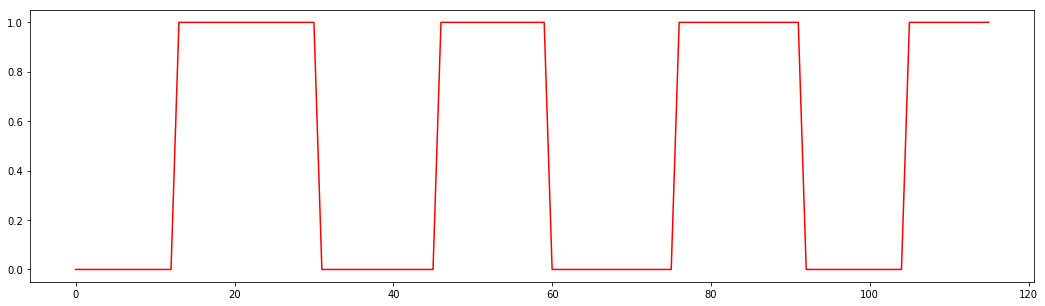

In [9]:
plt.figure(figsize=(18, 5))
plt.plot([i[0] for i in test_y[1]], 'r')
plt.show()

In [10]:
NUM_LAYERS=2

def LstmCell():
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_hidden)#, forget_bias=1.0)
    cell = tf.contrib.rnn.DropoutWrapper(lstm_cell, output_keep_prob=0.5)
    return cell

graph = tf.Graph()
with graph.as_default(), tf.device('/gpu:0'):
    # tf Graph input
    X = tf.placeholder("float", [None, timesteps, num_input])
    Y = tf.placeholder("float", [None, timesteps, num_output])
    
    # Define weights
    weights = {
        'out': tf.Variable(tf.random_normal([num_hidden, num_output]))
    }
    biases = {
        'out': tf.Variable(tf.random_normal([num_output]))
    }
    
    def RNN(x, weights, biases):
        x = tf.unstack(x, timesteps, 1)
        cell = tf.contrib.rnn.MultiRNNCell([LstmCell() for _ in range(NUM_LAYERS)])
        outputs, state = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
        outputs = tf.transpose(outputs, [1,0,2])

#         return tf.matmul(outputs[-2], weights['out']) + biases['out']
        ret = []
#         print(outputs.shape)
        for i in range(0, timesteps):
            ret.append(tf.matmul(outputs[i], weights['out']) + biases['out'])
            
        return ret

#         return np.array(ret)
    
    logits = RNN(X, weights, biases)
    logits = tf.transpose(logits, [1,0,2])
#     print(len(logits))
    print(logits.shape)
    print(logits[0].shape)
    mean_train = tf.reduce_mean(X)
    
    
    loss = tf.reduce_mean(tf.squared_difference(logits, Y))

    optimizer = tf.train.AdamOptimizer(learning_rate = 0.001).minimize(loss)
    
    saver = tf.train.Saver()

(?, 50, 1)
(50, 1)


In [11]:
batch_size = 256
batch_start = 0;
train_length = len(train_x)
print(train_length)

train_x_extend = [i for i in train_x]
train_y_extend = [i for i in train_y]

print(len(train_x_extend))

99853
99853


In [12]:
if(len(train_x_extend)==len(train_x)):
    train_x_extend.extend(train_x[0:batch_size])
    train_y_extend.extend(train_y[0:batch_size])
print(len(train_x_extend))

100109


In [13]:
def cal_accuarcy(y, _y):
#     print(len(y))
#     print(len(y[0]))
#     print(len(y[0][0]))
#     print(y[0][0])
    count = 0
    total = 0
    for i in range(len(y[0])):
        total += 1
        if(y[0][i][0] == round(_y[0][i][0])):
            count += 1
    for i in range(1, len(y)):
        total += 1
        if(y[i][-1][0] == round(_y[i][-1][0])):
            count += 1;
    return(count*1.0/total)
#     print("train accuarcy : ", count/len(y))

In [85]:
training_steps = 1001

config = tf.ConfigProto(allow_soft_placement=True)
# config.gpu_options.allocator_type = 'BFC'
# config.gpu_options.per_process_gpu_memory_fraction = 0.40
with tf.Session(graph=graph, config=config) as session:
    saver.restore(session, tf.train.latest_checkpoint('lstm_check'))
#     saver.restore(session, "lstm_check/my-model-gpu-dropout2-na-5050-leave.ckpt-5000")
#     tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(training_steps):      
        feed_dict = {X: train_x[batch_start:batch_start+batch_size], Y: train_y[batch_start:batch_start+batch_size]}
        _, l, predictions, m = session.run([optimizer, loss, logits, mean_train], feed_dict = feed_dict)
        if (step % 200 == 0):
            train_accuarcy = cal_accuarcy(train_y[batch_start:batch_start+batch_size], predictions)
            print('Loss at step %d: %f, train accuarcy : %f' % (step, l, train_accuarcy))
            #train accuarcy
        if (step % 1000 == 0):
            saver.save(session, 'lstm_check/my-model-gpu-dropout2-na-5050-leave-nofeature.ckpt', global_step=step+8000)
        batch_start += batch_size
        if(batch_start>=train_length):
            batch_start -=train_length
#     train_loss, train_logits = session.run([loss,logits], feed_dict={X: train_x, Y: train_y})
#     test_loss, test_logits = session.run([loss,logits], feed_dict={X: test_x, Y: test_y})
    test_loss, test_logits = [], []
    for i in range(len(test_x)):
        test_loss_part, test_logits_part = session.run([loss,logits], feed_dict={X: test_x[i], Y: test_y[i]})
#         print('test accuarcy', cal_accuarcy(test_y[i], test_logits_part))
        test_loss.append(test_loss_part)
        test_logits.append(test_logits_part)

INFO:tensorflow:Restoring parameters from lstm_check/my-model-gpu-dropout2-na-5050-leave-nofeature.ckpt-8000
Initialized
Loss at step 0: 0.044584, train accuarcy : 0.954098
Loss at step 200: 0.043708, train accuarcy : 0.960656
Loss at step 400: 0.042960, train accuarcy : 0.970492
Loss at step 600: 0.043372, train accuarcy : 0.957377
Loss at step 800: 0.039795, train accuarcy : 0.983607
Loss at step 1000: 0.042075, train accuarcy : 0.973770


56
775
50


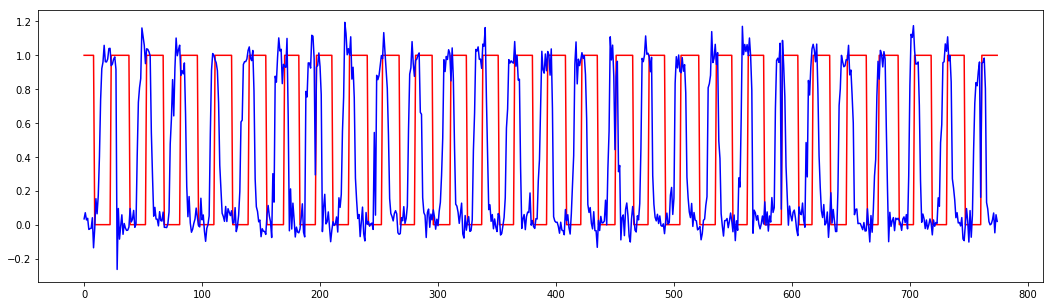

In [86]:
#bad 9 16
#good 6 18 19 29
# 17
index = 6

print(len(test_logits))
print(len(test_logits[index]))
print(len(test_logits[index][0]))

plt.figure(figsize=(18, 5))
plt.plot([i[-1][0] for i in test_y[index][0:1000]], 'r')
plt.plot([i[-1][0] for i in test_logits[index][0:1000]], 'b')

plt.show()

In [87]:
print("test loss : ", test_loss)

test loss :  [0.65867573, 0.57637471, 0.58917463, 0.64465821, 0.51383942, 0.50659806, 0.48114455, 0.5174697, 0.61579007, 0.58262104, 0.60161954, 0.62768435, 0.54451895, 0.50202584, 0.46524572, 0.52392471, 0.46626052, 0.59194511, 0.38384449, 0.41378766, 0.50414854, 0.51554179, 0.49020368, 0.56314886, 0.47697678, 0.55255687, 0.52506542, 0.59282553, 0.42458698, 0.42708704, 0.46431491, 0.43226707, 0.5063116, 0.46405917, 0.47553116, 0.43891048, 0.62694514, 0.5344907, 0.60249883, 0.53191954, 0.52076894, 0.51922596, 0.50251043, 0.48695892, 0.44260988, 0.47555125, 0.44796669, 0.45999801, 0.4644942, 0.45140377, 0.62257534, 0.56177396, 0.66846412, 0.50705248, 0.52220678, 0.50074714]


In [88]:
print(len(test_logits))
print(len(test_logits[0]))
print(len(test_logits[0][0]))  

test_y_seq_list, test_logits_bin_list = [], []

for t in test_logits:  
    t_all = [i for i in t[0]]
    t_all.extend([i[-1] for i in t[1:]])
#     print(len(t_all)-len(t))
    
    test_logits_part = [[round(i[0])] for i in t_all]
    for i in range(1, len(test_logits_part)-1):
        if(test_logits_part[i-1][0]!=test_logits_part[i][0] and test_logits_part[i-1][0]==test_logits_part[i+1][0]):
            test_logits_part[i][0]=test_logits_part[i-1][0]    
    test_logits_bin_list.append(test_logits_part)
    
for t in test_y:  
    t_all = [i for i in t[0]]
    t_all.extend([i[-1] for i in t[1:]])
    test_y_seq_list.append(t_all)

# print(test_y_seq_list)
    
count = 0
total = 0
for i in range(0, len(test_y_seq_list)):
    total += len(test_y_seq_list[i])
    for j in range(0, len(test_y_seq_list[i])):
        if(test_y_seq_list[i][j][0] == test_logits_bin_list[i][j][0]):
            count += 1

print(count)
print(total)
print("test accuarcy : ", count*1.0/total)

56
80
50
12571
29666
test accuarcy :  0.42375109553023665


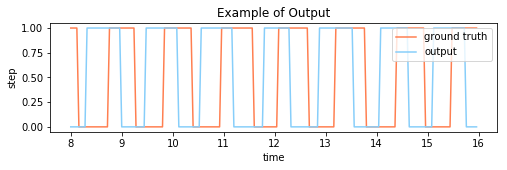

In [89]:
index = 2

start=200
end=400

plt.figure(figsize=(8, 2))
plt.title('Example of Output')
plt.xlabel('time')
plt.ylabel('step')
plt.plot([i/25.0 for i in range(start, end)], [i[0] for i in test_y_seq_list[index][start:end]], 'coral', label='ground truth')     
plt.plot([i/25.0 for i in range(start, end)], [i[0] for i in test_logits_bin_list[index][start:end]], 'lightskyblue', label='output')
plt.legend()
plt.show()

In [90]:
step_time_actual, step_time_predict= [], []
step_time_actual_gap = []

#test_y_seq_list, test_logits_bin_list
for i in range(0, len(test_y_seq_list)):
    step_time_actual_part, step_time_predict_part= [], []
    for j in range(1, len(test_y_seq_list[i])):
        if(abs(test_y_seq_list[i][j][0]-test_y_seq_list[i][j-1][0])>0.5):
            step_time_actual_part.append(j)
    #     if(abs(test_logits[i][0]-test_logits[i-1][0])>0.5):
        if(abs(test_logits_bin_list[i][j][0]-test_logits_bin_list[i][j-1][0])>0.5):
            step_time_predict_part.append(j)
    step_time_actual.append(step_time_actual_part)
    step_time_predict.append(step_time_predict_part)
    
    step_time_actual_gap_part = []
    step_time_actual_gap_part.append(0)
#     step_time_actual_gap_part.append(step_time_actual_part[0]/2.0)
    for i in range(1, len(step_time_actual_part)):
        step_time_actual_gap_part.append((step_time_actual_part[i-1]+step_time_actual_part[i])/2.0)
    step_time_actual_gap_part.append(step_time_actual_part[-1]*2)
    step_time_actual_gap.append(step_time_actual_gap_part)

print('Step number for each segement')
print([len(i) for i in step_time_actual])   
print([len(i) for i in step_time_predict])

print('======')
iii = 13
print(step_time_actual[iii])
print(step_time_actual_gap[iii])
print(step_time_predict[iii])

Step number for each segement
[8, 10, 57, 7, 8, 10, 57, 7, 9, 80, 11, 6, 9, 80, 11, 6, 84, 22, 84, 22, 17, 82, 10, 80, 12, 63, 11, 57, 17, 82, 10, 80, 12, 63, 11, 57, 6, 27, 46, 13, 31, 22, 82, 6, 27, 46, 13, 31, 22, 82, 43, 82, 58, 43, 82, 58]
[10, 12, 57, 7, 9, 11, 58, 8, 14, 74, 12, 6, 10, 82, 11, 7, 86, 22, 85, 23, 20, 82, 10, 75, 5, 60, 12, 57, 16, 86, 10, 79, 13, 60, 10, 63, 7, 31, 46, 12, 30, 23, 71, 6, 26, 44, 15, 33, 23, 83, 45, 87, 58, 45, 85, 57]
[16, 31, 46, 57, 74, 86, 103, 115, 132, 144, 160, 172, 188, 200, 218, 227, 244, 256, 271, 282, 299, 311, 327, 338, 354, 367, 382, 394, 411, 422, 439, 450, 466, 477, 493, 506, 526, 534, 551, 563, 580, 591, 608, 618, 635, 648, 663, 675, 691, 703, 720, 732, 749, 760, 776, 787, 802, 814, 830, 843, 857, 869, 885, 896, 912, 924, 941, 953, 968, 981, 997, 1010, 1026, 1038, 1053, 1068, 1082, 1095, 1111, 1123]
[0, 23.5, 38.5, 51.5, 65.5, 80.0, 94.5, 109.0, 123.5, 138.0, 152.0, 166.0, 180.0, 194.0, 209.0, 222.5, 235.5, 250.0, 263.5, 276.5, 290

In [91]:
total_step_count = sum([len(i) for i in step_time_actual])
metric1_undercount = 0
metric2_undercount = 0
metric3_undercount = 0
metric1_overcount = 0
metric2_overcount = 0
metric3_overcount = 0

metric2_overcount_list = []
metric3_overcount_list = []

print(len(test_x))

for i in range(len(test_x)):
    step_count = len(step_time_actual[i])
    undercount = 0
    overcount = 0

    for j in range(1, step_count):
        gap_count = [t for t in step_time_predict[i] if t>=step_time_actual[i][j-1] and t<step_time_actual[i][j]]
    #     print(gap_count)
        if(len(gap_count)>1):
            overcount += len(gap_count)-1
        if(len(gap_count)<1):
            undercount += 1
    gap_count = [t for t in step_time_predict[i] if t>=step_time_actual[i][-1]]
    if(len(gap_count)>1):
        overcount += len(gap_count)-1
    if(len(gap_count)<1):
        undercount += 1
    
    metric1_undercount += undercount
    metric1_overcount += overcount
    
    undercount = 0
    overcount = 0
    for j in range(1, len(step_time_actual_gap[i])):
        gap_count = [t for t in step_time_predict[i] if t>=step_time_actual_gap[i][j-1] and t<step_time_actual_gap[i][j]]
    #     print(gap_count)
        if(len(gap_count)>1):
            overcount += (len(gap_count)-1)
        if(len(gap_count)<1):
            undercount += 1    
    
    metric2_undercount += undercount
    metric2_overcount += overcount  
    metric2_overcount_list.append(overcount)
    
#     print(undercount, overcount)
#     print('undercount : ', undercount*1.0/step_count)
#     print('overcount : ', overcount*1.0/step_count)
    diff = len(step_time_predict[i])-len(step_time_actual[i])
#     if(diff==0):
#         print("segement correct!")

    if(diff<0):
#         print('segement undercount : ', 1-len(step_time_predict[i])*1.0/len(step_time_actual[i]))
        metric3_undercount -= diff
        metric3_overcount_list.append(0)
#     if(diff>=0):
    else:
#         print('segement overcount : ', 1-len(step_time_actual[i])*1.0/len(step_time_predict[i]))
        metric3_overcount += diff
        metric3_overcount_list.append(diff)

print(len(metric2_overcount_list))
print(sum(metric2_overcount_list))
print(metric2_overcount_list)
print(len(metric3_overcount_list))
print(sum(metric3_overcount_list))
print(metric3_overcount_list)
        
print('error : ')
print("total undercount metric 1:\t", metric1_undercount*1.0/total_step_count)
print("total overcount metric 1:\t", metric1_overcount*1.0/total_step_count)
print("total undercount metric 2:\t", metric2_undercount*1.0/total_step_count)
print("total overcount metric 2:\t", metric2_overcount*1.0/total_step_count)
print("total undercount metric 3:\t", metric3_undercount*1.0/total_step_count)
print("total overcount metric 3:\t", metric3_overcount*1.0/total_step_count)

56
56
644
[3, 4, 11, 0, 2, 3, 22, 2, 6, 22, 3, 0, 1, 34, 4, 2, 37, 2, 29, 11, 7, 25, 3, 13, 3, 14, 5, 6, 5, 39, 3, 37, 3, 23, 4, 27, 2, 10, 5, 3, 10, 6, 25, 1, 13, 13, 3, 14, 11, 35, 2, 18, 3, 10, 24, 21]
56
61
[2, 2, 0, 0, 1, 1, 1, 1, 5, 0, 1, 0, 1, 2, 0, 1, 2, 0, 1, 1, 3, 0, 0, 0, 0, 0, 1, 0, 0, 4, 0, 0, 1, 0, 0, 6, 1, 4, 0, 0, 0, 1, 0, 0, 0, 0, 2, 2, 1, 1, 2, 5, 0, 2, 3, 0]
error : 
total undercount metric 1:	 0.06805019305019305
total overcount metric 1:	 0.055984555984555984
total undercount metric 2:	 0.3026061776061776
total overcount metric 2:	 0.3108108108108108
total undercount metric 3:	 0.021235521235521235
total overcount metric 3:	 0.02944015444015444


In [48]:
# 6000 error : 
# total undercount metric 1 :  0.08759469696969698
# total overcount metric 1 :  0.1747159090909091
# total undercount metric 2 :  0.0
# total overcount metric 2 :  0.10085227272727272

# 4000 error : 
# total undercount metric 1 :  0.011837121212121212
# total overcount metric 1 :  0.029356060606060608
# total undercount metric 2 :  0.0023674242424242425
# total overcount metric 2 :  0.03172348484848485

# 4200 error : 
# total undercount metric 1 :  0.009943181818181818
# total overcount metric 1 :  0.026041666666666668
# total undercount metric 2 :  0.0033143939393939395
# total overcount metric 2 :  0.029356060606060608

#4000 no feature error : 
total undercount metric 1 :  0.1965648854961832
total overcount metric 1 :  0.20706106870229007
total undercount metric 2 :  0.03959923664122137
total overcount metric 2 :  0.055820610687022904

SyntaxError: invalid syntax (<ipython-input-48-7c248cdc26db>, line 20)